In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/step2_features_summary.csv')
df.head()

,Location,Time,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP
0,DEU,1961-03-31,7.450290,23.28992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEU,1961-06-30,5.002099,23.46389,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DEU,1961-09-30,3.576950,23.61611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEU,1961-12-31,2.996161,23.70309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DEU,1962-03-31,3.466854,24.07278,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9331 entries, 0 to 9330
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Location            9331 non-null   object 
 1   Time                9331 non-null   object 
 2   GDP_growth          9331 non-null   float64
 3   Inflation           8734 non-null   float64
 4   PPI                 4030 non-null   float64
 5   Unemployment        4957 non-null   float64
 6   House_price_income  4765 non-null   float64
 7   House_price_rent    4765 non-null   float64
 8   Rent_income         4765 non-null   float64
 9   HH_debt_income      791 non-null    float64
 10  Spending_to_GDP     830 non-null    float64
dtypes: float64(9), object(2)
memory usage: 802.0+ KB


In [4]:
df['Time'] = pd.to_datetime(df['Time'])
df['Time'].head()

0   1961-03-31
1   1961-06-30
2   1961-09-30
3   1961-12-31
4   1962-03-31
Name: Time, dtype: datetime64[ns]

Let's analyze USA from 1970 onwards and see if we can spot any patterns.

In [5]:
df_new = df[(df['Location'] == 'USA') & (df['Time'].dt.year > 1980)].sort_values('Time')
df_new.drop(columns='Location', inplace=True)
df_new.head()

,Time,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP
7217,1981-03-31,1.599982,37.04375,48.57440,7.4,128.706050,95.744366,1.344268,NaN,NaN
7218,1981-06-30,2.968692,37.90164,49.71286,7.5,128.812274,94.931508,1.356897,NaN,NaN
7219,1981-09-30,4.325757,38.97048,50.07510,7.6,126.297419,92.221887,1.369495,NaN,NaN
7220,1981-12-31,1.299913,39.53303,50.69608,8.5,125.234847,91.344168,1.371022,NaN,35.597875
7221,1982-03-31,-2.190342,39.85649,51.19631,9.0,124.997694,91.932696,1.359665,NaN,NaN


In [6]:
df_new.describe()

,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,24.000000,39.000000
mean,2.548010,74.371116,77.062005,6.200000,111.200734,99.082991,1.129454,115.669553,37.815706
std,2.208338,21.555794,19.017948,1.739899,9.575937,10.157876,0.115458,15.003031,1.946757
min,-9.032775,37.043750,48.574400,3.500000,90.532508,87.980633,0.867029,94.304690,34.298944
25%,1.721503,56.873560,62.301270,5.000000,105.288883,90.486625,1.017307,104.441150,36.719344
50%,2.716134,74.129710,72.020120,5.700000,109.574414,96.357979,1.111920,112.114050,37.767304
75%,4.049823,93.523390,98.086770,7.300000,117.770964,103.955218,1.218384,127.851225,38.278658
max,8.578274,111.029000,109.673900,11.100000,133.077012,127.505856,1.376032,143.611100,43.262507


Interpolate, then difference and transform time series.

In [7]:
df_new['HH_debt_income'] = df_new['HH_debt_income'].interpolate('linear')
df_new['Spending_to_GDP'] = df_new['Spending_to_GDP'].interpolate('linear')

In [8]:
df_new['HH_debt_income_diff'] = df_new['HH_debt_income'].diff(4)
# df_new['HH_debt_income_log_diff'] = np.log(df_new['HH_debt_income']).diff(4)

In [9]:
df_new['Spending_to_GDP_diff'] = df_new['Spending_to_GDP'].diff(4)
# df_new['Spending_to_GDP_log_diff'] = np.log(df_new['Spending_to_GDP']).diff(4)

In [10]:
df_new['Unemployment_diff'] = df_new['Unemployment'].diff(4)
# df_new['Unemployment_log_diff'] = np.log(df_new['Unemployment']).diff(4)

In [11]:
df_new['House_price_income_diff'] = df_new['House_price_income'].diff(4)
# df_new['House_price_income_log_diff'] = np.log(df_new['House_price_income']).diff(4)

df_new['House_price_rent_diff'] = df_new['House_price_rent'].diff(4)
# df_new['House_price_rent_log_diff'] = np.log(df_new['House_price_rent']).diff(4)

df_new['Rent_income_diff'] = df_new['Rent_income'].diff(4)

In [12]:
df_new['Inflation_diff'] = df_new['Inflation'].diff(4)
# df_new['Inflation_log_diff'] = np.log(df_new['Inflation']).diff(4)

In [13]:
df_new['PPI_diff'] = df_new['PPI'].diff(4)
# df_new['PPI_log_diff'] = np.log(df_new['PPI']).diff(4)

### Set index

In [14]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 7217 to 7377
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Time                     161 non-null    datetime64[ns]
 1   GDP_growth               161 non-null    float64       
 2   Inflation                161 non-null    float64       
 3   PPI                      161 non-null    float64       
 4   Unemployment             161 non-null    float64       
 5   House_price_income       161 non-null    float64       
 6   House_price_rent         161 non-null    float64       
 7   Rent_income              161 non-null    float64       
 8   HH_debt_income           102 non-null    float64       
 9   Spending_to_GDP          158 non-null    float64       
 10  HH_debt_income_diff      98 non-null     float64       
 11  Spending_to_GDP_diff     154 non-null    float64       
 12  Unemployment_diff        157 non

In [15]:
df_new.set_index('Time', inplace=True)
df_new.head()

,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP,HH_debt_income_diff,Spending_to_GDP_diff,Unemployment_diff,House_price_income_diff,House_price_rent_diff,Rent_income_diff,Inflation_diff,PPI_diff
Time,,,,,,,,,,,,,,,,,
1981-03-31,1.599982,37.04375,48.57440,7.4,128.706050,95.744366,1.344268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-06-30,2.968692,37.90164,49.71286,7.5,128.812274,94.931508,1.356897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-09-30,4.325757,38.97048,50.07510,7.6,126.297419,92.221887,1.369495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-12-31,1.299913,39.53303,50.69608,8.5,125.234847,91.344168,1.371022,NaN,35.597875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-03-31,-2.190342,39.85649,51.19631,9.0,124.997694,91.932696,1.359665,NaN,36.160513,NaN,NaN,1.6,-3.708356,-3.81167,0.015398,2.81274,2.62191


### Missing value

In [16]:
# count missing values in df
missing = pd.concat([df_new.isnull().sum(), df_new.isnull().mean()*100], axis=1)
missing.columns=['nan counts', 'missing %']
missing.sort_values(by='missing %', ascending=False)

,nan counts,missing %
HH_debt_income_diff,63,39.130435
HH_debt_income,59,36.645963
Spending_to_GDP_diff,7,4.347826
PPI_diff,4,2.484472
Inflation_diff,4,2.484472
Rent_income_diff,4,2.484472
House_price_rent_diff,4,2.484472
House_price_income_diff,4,2.484472
Unemployment_diff,4,2.484472
Spending_to_GDP,3,1.863354


In [17]:
df_new.dropna(subset=['HH_debt_income_diff'], inplace=True)
df_new.head()

,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP,HH_debt_income_diff,Spending_to_GDP_diff,Unemployment_diff,House_price_income_diff,House_price_rent_diff,Rent_income_diff,Inflation_diff,PPI_diff
Time,,,,,,,,,,,,,,,,,
1996-12-31,4.421215,66.87284,69.02003,5.4,105.288883,89.108141,1.181585,96.221010,37.123526,1.916320,-0.685060,-0.2,-1.699095,-0.197941,-0.016407,2.06736,1.56292
1997-03-31,4.314064,67.32288,68.94817,5.2,104.808567,88.978814,1.177905,96.501558,36.834758,1.717788,-0.802563,-0.3,-1.822046,-0.387705,-0.015278,1.92672,1.13177
1997-06-30,4.308066,67.59009,68.71463,5.0,104.786659,89.036092,1.176901,96.782105,36.545989,1.519255,-0.920067,-0.3,-1.173556,-0.301516,-0.009164,1.54701,0.21558
1997-09-30,4.673886,67.85730,68.55295,4.9,104.362322,89.003815,1.172560,97.062652,36.257221,1.320723,-1.037570,-0.3,-1.287230,-0.176143,-0.012118,1.46262,-0.07186
1997-12-31,4.487859,68.12451,68.64278,4.7,103.939792,89.182600,1.165472,97.343200,35.968453,1.122190,-1.155073,-0.7,-1.349091,0.074460,-0.016114,1.25167,-0.37725


In [18]:
df_new.describe()

,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP,HH_debt_income_diff,Spending_to_GDP_diff,Unemployment_diff,House_price_income_diff,House_price_rent_diff,Rent_income_diff,Inflation_diff,PPI_diff
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,2.186469,88.886484,89.070182,5.777551,108.713358,103.759639,1.049764,115.990556,37.961568,0.390057,0.024130,0.102041,0.082654,1.098306,-0.010517,1.798061,1.507744
std,2.169501,13.211199,14.238603,1.809798,10.658268,10.455098,0.061160,13.961260,2.276101,4.330806,1.060416,1.365328,5.120013,4.930298,0.023570,0.943474,3.370233
min,-9.032775,66.872840,67.924190,3.500000,90.532508,88.978814,0.867029,96.221010,34.298944,-7.271000,-1.819629,-1.400000,-15.571455,-14.077504,-0.136863,-1.501860,-8.263730
25%,1.576946,76.629525,73.300098,4.425000,102.520041,96.588681,1.002789,104.579700,36.759770,-2.467219,-0.644670,-0.600000,-1.821885,-0.192492,-0.021614,1.304428,-0.404205
50%,2.364005,90.706785,91.682385,5.150000,106.317382,101.132079,1.037425,111.479425,37.898500,0.044700,-0.126152,-0.300000,1.102598,1.982885,-0.011195,1.802350,1.473100
75%,3.412170,100.139625,103.067450,6.600000,112.546769,109.001558,1.100356,127.396788,38.596616,3.513645,0.326129,0.275000,3.230310,3.212601,0.000830,2.287800,3.700710
max,5.297738,111.029000,109.673900,11.100000,133.077012,127.505856,1.181585,143.611100,43.262507,8.099500,3.439162,7.500000,8.603156,11.553248,0.046785,4.658890,10.688950


In [19]:
df_new.describe()

,GDP_growth,Inflation,PPI,Unemployment,House_price_income,House_price_rent,Rent_income,HH_debt_income,Spending_to_GDP,HH_debt_income_diff,Spending_to_GDP_diff,Unemployment_diff,House_price_income_diff,House_price_rent_diff,Rent_income_diff,Inflation_diff,PPI_diff
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,2.186469,88.886484,89.070182,5.777551,108.713358,103.759639,1.049764,115.990556,37.961568,0.390057,0.024130,0.102041,0.082654,1.098306,-0.010517,1.798061,1.507744
std,2.169501,13.211199,14.238603,1.809798,10.658268,10.455098,0.061160,13.961260,2.276101,4.330806,1.060416,1.365328,5.120013,4.930298,0.023570,0.943474,3.370233
min,-9.032775,66.872840,67.924190,3.500000,90.532508,88.978814,0.867029,96.221010,34.298944,-7.271000,-1.819629,-1.400000,-15.571455,-14.077504,-0.136863,-1.501860,-8.263730
25%,1.576946,76.629525,73.300098,4.425000,102.520041,96.588681,1.002789,104.579700,36.759770,-2.467219,-0.644670,-0.600000,-1.821885,-0.192492,-0.021614,1.304428,-0.404205
50%,2.364005,90.706785,91.682385,5.150000,106.317382,101.132079,1.037425,111.479425,37.898500,0.044700,-0.126152,-0.300000,1.102598,1.982885,-0.011195,1.802350,1.473100
75%,3.412170,100.139625,103.067450,6.600000,112.546769,109.001558,1.100356,127.396788,38.596616,3.513645,0.326129,0.275000,3.230310,3.212601,0.000830,2.287800,3.700710
max,5.297738,111.029000,109.673900,11.100000,133.077012,127.505856,1.181585,143.611100,43.262507,8.099500,3.439162,7.500000,8.603156,11.553248,0.046785,4.658890,10.688950


## Visualization

In [20]:
cols = df_new.columns
cols

Index(['GDP_growth', 'Inflation', 'PPI', 'Unemployment', 'House_price_income',
       'House_price_rent', 'Rent_income', 'HH_debt_income', 'Spending_to_GDP',
       'HH_debt_income_diff', 'Spending_to_GDP_diff', 'Unemployment_diff',
       'House_price_income_diff', 'House_price_rent_diff', 'Rent_income_diff',
       'Inflation_diff', 'PPI_diff'],
      dtype='object')

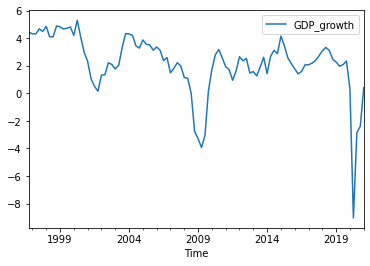

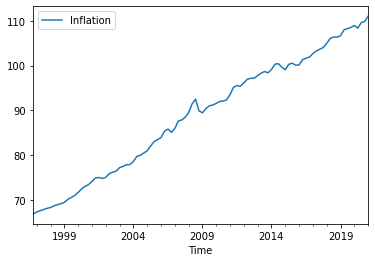

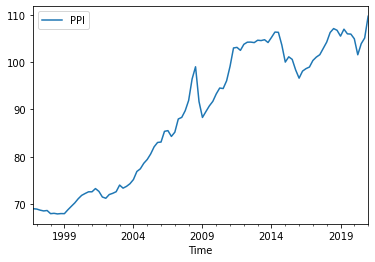

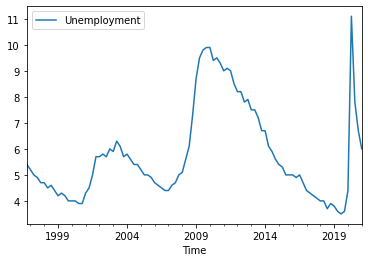

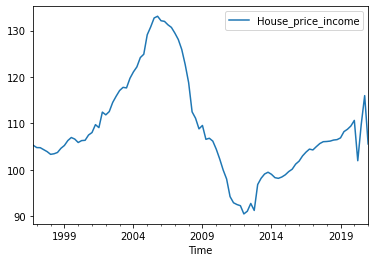

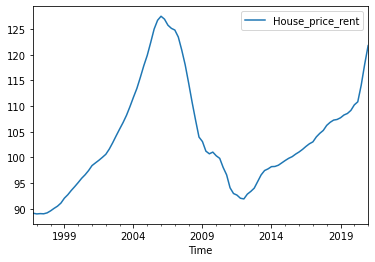

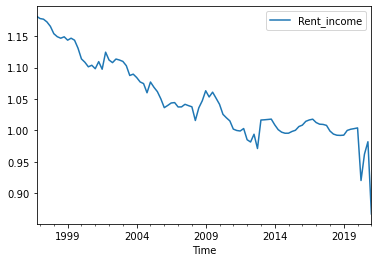

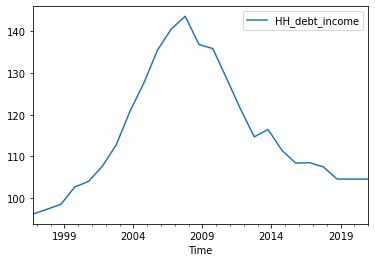

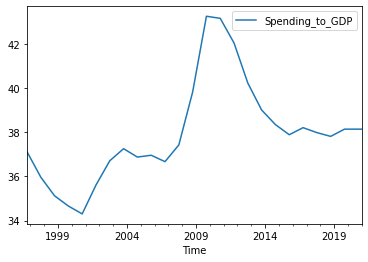

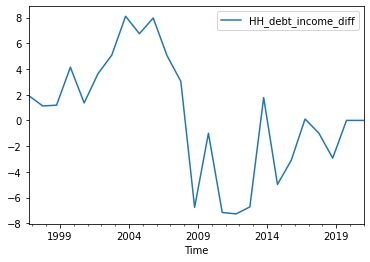

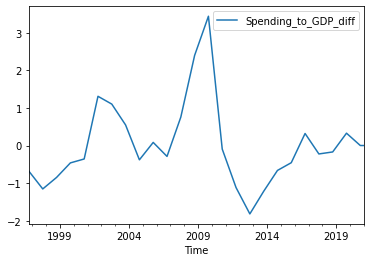

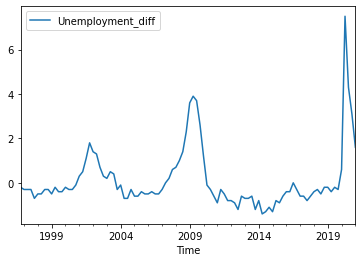

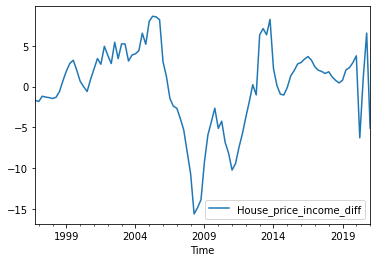

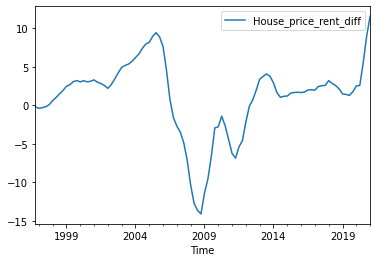

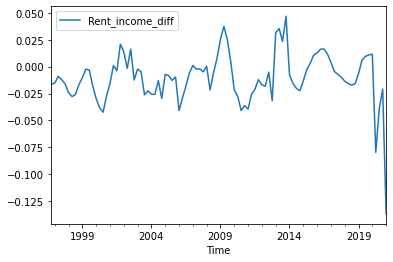

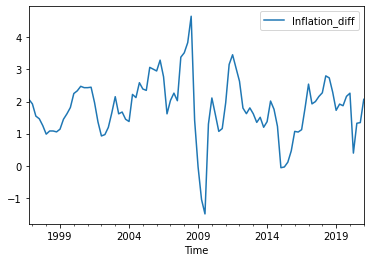

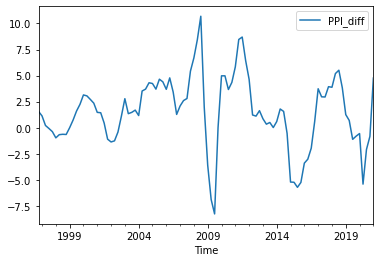

In [21]:
for i in range(0, len(cols)):
    df_new.plot(y=cols[i])
plt.show()

## Stationarity test

In [22]:
# Augmented Dickey Fuller test
def apply_adf(timeseries):
    print('Dickey-Fuller test (difference test):')
    print('Null hypothesis: series is not stationary')
    result = adfuller(timeseries, autolag='AIC')
    output = pd.Series(result[0:4], index=['Test statistics', 'p-value', 'Lags used', 'Observations used'])
    for k, v in result[4].items():
        output[f'Critical value ({k})'] = v
    print(output)
    for i, value in enumerate(result[4].values()):
        if result[0] > value:
            print(f'Fail to reject null hypothesis at critical value {i+1}: series is not stationary')
        else:
            print(f'Reject null hypothesis at critical value {i+1}: series is stationary')

In [23]:
# KPSS test
def apply_kpss(timeseries):
    result = kpss(timeseries, regression='c')
    output = pd.Series(result[0:3], index=['Test statistics', 'p-value', 'Lags used'])
    for k, v in result[3].items():
        output[f'Critical value ({k})'] = v
    print('KPSS test (trend test):')
    print('Null hypothesis: series is stationary')
    print(output)
    for i, value in enumerate(result[3].values()):
        if result[0] > value:
            print(f'Reject null hypothesis at critical value {i+1}: series is not stationary')
        else:
            print(f'Fail to reject null hypothesis at critical value {i+1}: series is stationary')

In [24]:
for i in range(len(df_new.columns)):
    print("=============================================")
    print(df_new.columns[i])
    apply_adf(df_new[df_new.columns[i]])
    print()
    apply_kpss(df_new[df_new.columns[i]])
    print()

GDP_growth
Dickey-Fuller test (difference test):
Null hypothesis: series is not stationary
Test statistics         -3.394415
p-value                  0.011151
Lags used                0.000000
Observations used       97.000000
Critical value (1%)     -3.499637
Critical value (5%)     -2.891831
Critical value (10%)    -2.582928
dtype: float64
Fail to reject null hypothesis at critical value 1: series is not stationary
Reject null hypothesis at critical value 2: series is stationary
Reject null hypothesis at critical value 3: series is stationary

KPSS test (trend test):
Null hypothesis: series is stationary
Test statistics           0.401707
p-value                   0.076420
Lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64
Reject null hypothesis at critical value 1: series is not stationary
Fail to reject null hypothesis at critical value 2: serie

Test statistics         -1.257655
p-value                  0.648316
Lags used               12.000000
Observations used       85.000000
Critical value (1%)     -3.509736
Critical value (5%)     -2.896195
Critical value (10%)    -2.585258
dtype: float64
Fail to reject null hypothesis at critical value 1: series is not stationary
Fail to reject null hypothesis at critical value 2: series is not stationary
Fail to reject null hypothesis at critical value 3: series is not stationary

KPSS test (trend test):
Null hypothesis: series is stationary
Test statistics           0.109626
p-value                   0.100000
Lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64
Fail to reject null hypothesis at critical value 1: series is stationary
Fail to reject null hypothesis at critical value 2: series is stationary
Fail to reject null hypothesis at critical valu

Let's set the critical value at 5% for the stationarity test.

Columns passed: GDP_growth, Spending_to_GDP_diff, Unemployment_diff, Rent_income_diff, Inflation_diff

Columns failed: HH_debt_income_diff, House_price_income_diff, House_price_rent_diff, PPI_diff.
These columns will undergo the second differencing.

In [25]:
df_new['HH_debt_income_diff_2'] = df_new['HH_debt_income_diff'].diff(4)
df_new['House_price_income_diff_2'] = df_new['House_price_income_diff'].diff(4)
df_new['House_price_rent_diff_2'] = df_new['House_price_rent_diff'].diff(4)
df_new['PPI_diff_2'] = df_new['PPI_diff'].diff(4)

In [26]:
df_new.dropna(inplace=True)

In [27]:
cols_2 = ['HH_debt_income_diff_2', 'House_price_income_diff_2', 'House_price_rent_diff_2', 'PPI_diff_2']

In [28]:
for i in range(len(cols_2)):
    print("=============================================")
    print(cols_2[i])
    apply_adf(df_new[cols_2[i]])
    print()
    apply_kpss(df_new[cols_2[i]])
    print()

HH_debt_income_diff_2
Dickey-Fuller test (difference test):
Null hypothesis: series is not stationary
Test statistics         -0.947743
p-value                  0.771844
Lags used               12.000000
Observations used       81.000000
Critical value (1%)     -3.513790
Critical value (5%)     -2.897943
Critical value (10%)    -2.586191
dtype: float64
Fail to reject null hypothesis at critical value 1: series is not stationary
Fail to reject null hypothesis at critical value 2: series is not stationary
Fail to reject null hypothesis at critical value 3: series is not stationary

KPSS test (trend test):
Null hypothesis: series is stationary
Test statistics           0.110414
p-value                   0.100000
Lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64
Fail to reject null hypothesis at critical value 1: series is stationary
Fail to reject nul

Only PPI_diff_2 is stationary. Thus, other columns that failed the stationarity tests after 2nd differencing will be dropped.

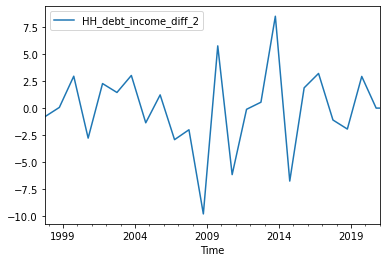

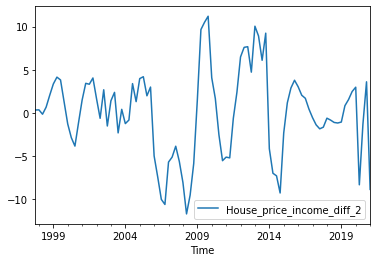

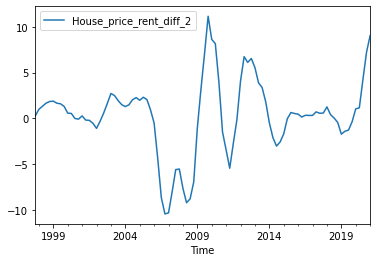

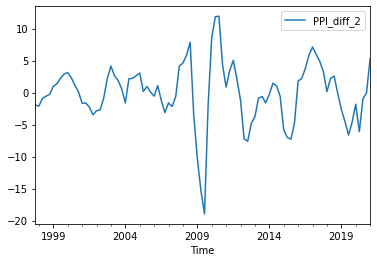

In [29]:
for i in range(0, len(cols_2)):
    df_new.plot(y=cols_2[i])
plt.show()

In [30]:
df_final = df_new[['GDP_growth', 'Spending_to_GDP_diff', 'Unemployment_diff', 'Rent_income_diff', 'Inflation_diff', 'PPI_diff_2']]
df_final.describe()

,GDP_growth,Spending_to_GDP_diff,Unemployment_diff,Rent_income_diff,Inflation_diff,PPI_diff_2
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,2.091029,0.061808,0.118085,-0.010401,1.800067,-0.068036
std,2.163947,1.066278,1.392064,0.024057,0.962070,4.748891
min,-9.032775,-1.819629,-1.400000,-0.136863,-1.501860,-18.952680
25%,1.504706,-0.559768,-0.600000,-0.022274,1.263270,-2.061437
50%,2.324297,-0.091719,-0.300000,-0.010085,1.802350,0.035915
75%,3.296804,0.438832,0.300000,0.001084,2.324027,2.506140
max,5.297738,3.439162,7.500000,0.046785,4.658890,11.928510


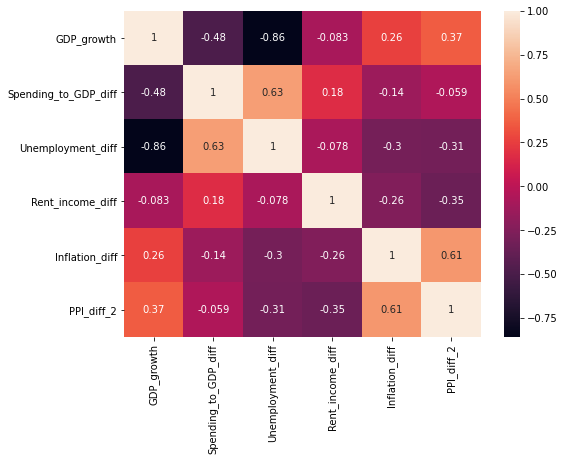

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(df_final.corr(), annot=True)

A basic heatmap gives us the expectation of which features are more correlated with GDP growth.

We can see that unemployment pct change is highly negatively correlated with GDP pct change. It is logical, because high unemployment rate usually happens during economic recession.

Inflation and PPI are moderately low correlated with GDP. This seems reasonable, as GDP grows, it is usually associated with higher inflation and higher product price.

Rent to income shows slightly correlated with GDP growth.

In [32]:
df_final.to_csv('data/step3_features_summary.csv')